In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

## Constants

In [2]:
X_START = -1
X_END = 1
T_START = 0
T_END = 1
NX = int((X_END - X_START)/0.025)
NT = int((T_END - T_START)/0.0025)
ALPHA = 1./jnp.pi**2

## Space-Time Domain

In [3]:
x = jnp.linspace(X_START, X_END, NX + 1)
dx = x[1] - x[0]

t = jnp.linspace(T_START, T_END, NT + 1)
dt = t[1] - t[0]

In [4]:
beta = ALPHA * dt / dx**2

# Utils for plotting 

In [5]:
# U = jnp.zeros((NT + 1, NX + 1))
u = -jnp.sin(jnp.pi * x)

def exact_soln(t, x):
    return -jnp.exp(-t) * jnp.sin(jnp.pi * x)

def error(u_exact, u_num):
    return jnp.absolute(u_exact - u_num)

## Main time loop function

In [6]:
@partial(jax.jit, static_argnames =['NX', 'NT'])
def rk3_num_loop(u, beta, NX, NT):
    
    u1, u2 = jnp.zeros(NX + 1), jnp.zeros(NX + 1)
    
    for _ in jnp.arange(1, NT + 1):
        
        slice_x_0 = jax.lax.slice_in_dim(u, 0, NX - 1)
        slice_x_1 = jax.lax.slice_in_dim(u, 1, NX)
        slice_x_2 = jax.lax.slice_in_dim(u, 2, NX+1)
        
        u1 = u1.at[1:NX].set(slice_x_1 + beta * (slice_x_2 - 2. * slice_x_1 + slice_x_0))
        
        slice_x_0 = jax.lax.slice_in_dim(u1, 0, NX - 1)
        slice_x_1 = jax.lax.slice_in_dim(u1, 1, NX)
        slice_x_2 = jax.lax.slice_in_dim(u1, 2, NX+1)
        
        u2 = u2.at[1:NX].set(0.75 * jax.lax.slice_in_dim(u, 1, NX) + 0.25 * ( jax.lax.slice_in_dim(u1, 1, NX) + beta * (slice_x_2 - 2. * slice_x_1 + slice_x_0)))
        
        slice_x_0 = jax.lax.slice_in_dim(u2, 0, NX - 1)
        slice_x_1 = jax.lax.slice_in_dim(u2, 1, NX)
        slice_x_2 = jax.lax.slice_in_dim(u2, 2, NX+1)
                
        u = u.at[1:NX].set(1/3 * jax.lax.slice_in_dim(u, 1, NX) + 2/3 * ( jax.lax.slice_in_dim(u2, 1, NX) + beta * (slice_x_2 - 2. * slice_x_1 + slice_x_0)))
        
        u = u.at[0].set(0)
        u = u.at[-1].set(0)
        
    return u

In [7]:
u = rk3_num_loop(u, beta, NX, NT)

In [8]:
u_exact_at_1 = exact_soln(1, x)
norm_error = error(u_exact_at_1, u)
max_norm_error = jnp.max(norm_error)

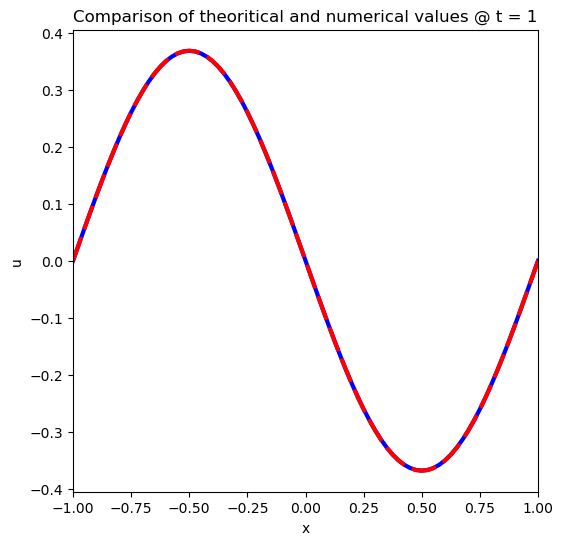

In [9]:
plt.figure(figsize=(6,6))
plt.plot(x, u_exact_at_1, c="b", linewidth=3)
plt.plot(x, u, c="red", dashes=[6,2], linewidth=3)
plt.xlabel("x")
plt.ylabel("u")
plt.xlim((-1,1))
plt.title("Comparison of theoritical and numerical values @ t = 1")
plt.show()

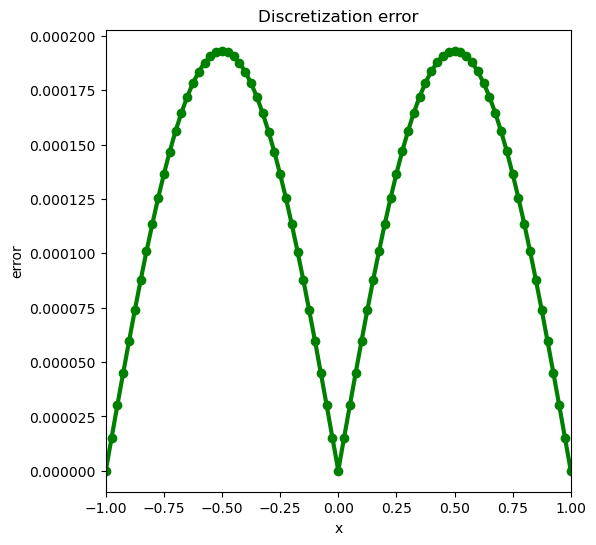

In [10]:
plt.figure(figsize=(6,6))
plt.plot(x, norm_error, c="g", linewidth=3, marker="o")
plt.xlabel("x")
plt.ylabel("error")
plt.xlim((-1,1))
plt.title("Discretization error")
plt.show()